In [ ]:
%%bash
if [ $(pip list --disable-pip-version-check | grep -c -w 'ismrmrd ') == 0 ] 
then 
    git clone https://github.com/ismrmrd/ismrmrd-python.git /var/tmp/ismrmrd-python
    python -m pip install --disable-pip-version-check -r /var/tmp/ismrmrd-python/requirements.txt
    python -m pip install --disable-pip-version-check /var/tmp/ismrmrd-python
    rm -rf /var/tmp/ismrmrd-python
fi
pip list --disable-pip-version-check | grep -w 'ismrmrd '

In [ ]:
%%bash
if [ $(pip list --disable-pip-version-check | grep -c -w 'ismrmrd-python-tools ') == 0 ] 
then 
    git clone https://github.com/ismrmrd/ismrmrd-python-tools.git /var/tmp/ismrmrd-python-tools
    python -m pip install --disable-pip-version-check /var/tmp/ismrmrd-python-tools
    rm -rf /var/tmp/ismrmrd-python-tools
fi
pip list --disable-pip-version-check | grep -w 'ismrmrd-python-tools '

# data preprocessing

In [ ]:
'''
[kx, ky, kz, coil, phase, set, slice, rep, avg], 
frequency encoding, first phase encoding, second phase encoding, 
coil, phase (time), set (velocity encoding), slice, repetition, and number of averages

better not to take average over the repetition dimension
'''

In [4]:
import os
from RL_samp import read_ocmr as read
import matplotlib.pyplot as plt
import math
## need to install ismrmrd and ismrmrdtools
from ismrmrdtools import show, transform
from pdb import set_trace as breakpoint
import shutil
import numpy as np
import torch

In [ ]:
datapath = '/home/ec2-user/SageMaker/data/OCMR_data/' # change this path to your directory
h5files = list([])
for file in os.listdir(datapath):
    if file.endswith(".h5"):
        h5files.append(file)
print('total amount of files:', len(h5files))

In [ ]:
regular_files = []
for file in h5files:
    kData,param = read.read_ocmr(datapath+file)
    print('filename', file, 'Dimension of kData: ', kData.shape)
    curr_shape = kData.shape
    if curr_shape[0]==384 and curr_shape[1]==144:
        regular_files.append([file, curr_shape])

### save these useful files
path = '/home/ec2-user/SageMaker/RLsamp/useful_files.npz'  # change this path to your directory
np.savez(path,files=regular_files)

In [7]:
regular_files = np.load('/home/ec2-user/SageMaker/RLsamp/useful_files.npz',allow_pickle=True)['files']
print(regular_files)
datapath = '/home/ec2-user/SageMaker/data/OCMR_data/' # change this path to your directory

[['fs_0024_3T.h5' (384, 144, 1, 38, 22, 1, 1, 1, 1)]
 ['us_0024_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0040_3T.h5' (384, 144, 1, 30, 65, 1, 1, 1, 1)]
 ['us_0075_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0010_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0006_3T.h5' (384, 144, 1, 30, 65, 1, 1, 1, 1)]
 ['fs_0033_3T.h5' (384, 144, 1, 34, 18, 1, 1, 1, 2)]
 ['fs_0074_1_5T.h5' (384, 144, 1, 24, 19, 1, 12, 1, 1)]
 ['us_0055_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['fs_0020_3T.h5' (384, 144, 1, 38, 22, 1, 1, 1, 1)]
 ['us_0025_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0015_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0059_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0068_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0067_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0004_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['fs_0011_1_5T.h5' (384, 144, 1, 18, 22, 1, 1, 1, 1)]
 ['us_0002_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0026_3T.h5' (384, 144, 1, 34, 65, 1

In [5]:
savepath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/' # change this path where you save processed data
if os.path.exists(savepath):
    shutil.rmtree(savepath)
os.mkdir(savepath)
print(f'~~~ directory {savepath} is created!')
  

~~~ directory /home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/ is created!


In [ ]:
for fileind in range(len(regular_files)):
    filename    = regular_files[fileind][0]
    kData,param = read.read_ocmr(datapath+filename)
    kData_tmp   = np.mean(kData, axis = 8) # average the k-space if average > 1, remove a dimension
    # Image reconstruction (SoS)
    im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]) # IFFT (2D image)
    im_sos  = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)) # Sum of Square, remove a dimension
    print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
    RO    = im_sos.shape[0]
    image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:] # Remove RO oversampling
    print('Dimension of Image (without ReadOout ovesampling): ', image.shape)
    
    for sliceind in range(image.shape[5]):
        image[:,:,:,:,:,sliceind,:] /= image[:,:,:,:,:,sliceind,:].max() # normalization of the image
    
    torch.save(torch.tensor(image) , savepath + filename[:-3] + '.pt')
    print(f'file {savepath + filename} is successfully saved')

Imaging acquisition starts acq  0
Dimension of Image (with ReadOut ovesampling):  (384, 144, 1, 22, 1, 1, 1)
Dimension of Image (without ReadOout ovesampling):  (192, 144, 1, 22, 1, 1, 1)
file /home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/fs_0024_3T.h5 is successfully saved
Imaging acquisition starts acq  32
Dimension of Image (with ReadOut ovesampling):  (384, 144, 1, 65, 1, 1, 1)
Dimension of Image (without ReadOout ovesampling):  (192, 144, 1, 65, 1, 1, 1)
file /home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/us_0024_3T.h5 is successfully saved
Imaging acquisition starts acq  32
Dimension of Image (with ReadOut ovesampling):  (384, 144, 1, 65, 1, 1, 1)
Dimension of Image (without ReadOout ovesampling):  (192, 144, 1, 65, 1, 1, 1)
file /home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/us_0040_3T.h5 is successfully saved
Imaging acquisition starts acq  32
Dimension of Image (with ReadOut ovesampling):  (384, 144, 1, 65, 1, 1, 1)
Dimension of Image (without ReadO

# view an example file

In [9]:
regular_files = np.load('/home/ec2-user/SageMaker/RLsamp/useful_files.npz',allow_pickle=True)['files']
print(regular_files)

[['fs_0024_3T.h5' (384, 144, 1, 38, 22, 1, 1, 1, 1)]
 ['us_0024_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0040_3T.h5' (384, 144, 1, 30, 65, 1, 1, 1, 1)]
 ['us_0075_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0010_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0006_3T.h5' (384, 144, 1, 30, 65, 1, 1, 1, 1)]
 ['fs_0033_3T.h5' (384, 144, 1, 34, 18, 1, 1, 1, 2)]
 ['fs_0074_1_5T.h5' (384, 144, 1, 24, 19, 1, 12, 1, 1)]
 ['us_0055_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['fs_0020_3T.h5' (384, 144, 1, 38, 22, 1, 1, 1, 1)]
 ['us_0025_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0015_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0059_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0068_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0067_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0004_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['fs_0011_1_5T.h5' (384, 144, 1, 18, 22, 1, 1, 1, 1)]
 ['us_0002_3T.h5' (384, 144, 1, 34, 65, 1, 1, 1, 1)]
 ['us_0026_3T.h5' (384, 144, 1, 34, 65, 1

In [ ]:
regular_files[0][0]

In [17]:
datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/' # change as needed
file = 'us_0018_3T.pt'  # pick an example file
data = torch.load(datapath+file)

In [ ]:
data.shape

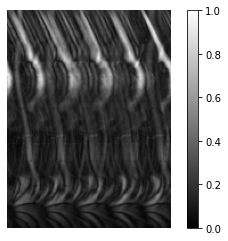

In [ ]:
# Show the reconstructed cine image
from IPython.display import clear_output
import time

slc_idx = 0 # math.floor(SLC/2)
print(slc_idx)
for rep in range(1): # repeat the movie for 5 times
    for frame in range(data.shape[3]):
        clear_output(wait=True)
        plt.imshow(data[:,:,0,frame,0,slc_idx,:], vmin=0, vmax=data.max(), cmap = 'gray'); plt.axis('off');
        plt.colorbar()
        plt.show() 
        time.sleep(0.03)

## reference viewing procedure (from original source data)

In [ ]:
# Load the data, display size of kData and scan parmaters
filename = '/home/ec2-user/SageMaker/data/OCMR_data/fs_0028_3T.h5'
kData,param = read.read_ocmr(filename);
print('Dimension of kData: ', kData.shape)

In [ ]:
# Image reconstruction (SoS)
dim_kData = kData.shape; CH = dim_kData[3]; SLC = dim_kData[6]; 
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1

im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
im_sos = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)); # Sum of Square
print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
RO = im_sos.shape[0];
image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:]; # Remove RO oversampling
print('Dimension of Image (without ReadOout ovesampling): ', image.shape)

In [ ]:
# Show the reconstructed cine image
from IPython.display import clear_output
import time

slc_idx = math.floor(SLC/2);
print(slc_idx)
image_slc = np.squeeze(image[:,:,:,:,:,slc_idx,:]);
for rep in range(5): # repeate the movie for 5 times
    for frame in range(image_slc.shape[2]):
      clear_output(wait=True)
      plt.imshow(image_slc[:,:,frame], vmin=0, vmax=0.6*np.amax(image_slc), cmap = 'gray'); plt.axis('off');
      plt.show() 
      time.sleep(0.03)